# 读取数据集

In [2]:
import torch

from torchvision import datasets
from torchvision import transforms

In [3]:
imageSize = 448

In [4]:
dataTtransform = transforms.Compose([
    transforms.Resize([imageSize, imageSize]),
    transforms.ToTensor(),
])

In [ ]:
def encodeVoc

In [5]:
VocTrainSet = datasets.VOCDetection("../input/pascal-voc-2007-and-2012", year="2012", image_set="train", transform=dataTtransform)
VocValidSet = datasets.VOCDetection("../input/pascal-voc-2007-and-2012", year="2012", image_set="val", transform=transforms.ToTensor())
VocTrainValidSet = datasets.VOCDetection("../input/pascal-voc-2007-and-2012", year="2012", image_set="trainval", transform=transforms.ToTensor())

In [6]:
trainLoader = torch.utils.data.DataLoader(VocTrainSet)
validLoader = torch.utils.data.DataLoader(VocValidSet)
trainValidLoader = torch.utils.data.DataLoader(VocTrainValidSet)

# 定义网络模型

In [7]:
from torch import nn

YOLO-V1网络架构如下：

![](https://img-blog.csdnimg.cn/20201210204826484.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3dlaXhpbl80MzMzNjI4MQ==,size_16,color_FFFFFF,t_70)

网络有24个卷积层和2个全连接层，根据图示建立7个卷积模块，前6个模块最后1个卷积层使用步长为2的卷积减少特征空间采样。

卷积层和全连接层之间通过Flatten将一个连续的尺寸范围展平为张量，然后用Linear对传入数据应用线性变换，最后输出特征为7 * 7 * 24，表示7 * 7的预测网格，每个预测网格预测20个条件类概率和4个Bounding Boxes坐标。

In [8]:
class YoloV1Model(nn.Module):
    def __init__(self):
        super(YoloV1Model, self).__init__()
        self.classes = 20
        self.convLayer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=7 // 2),
            nn.LeakyReLU(negative_slope=0.1),
        )
        self.convLayer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, stride=2, padding=3 // 2),
            nn.LeakyReLU(negative_slope=0.1),
        )
        self.convLayer3 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=128, kernel_size=1, padding=1 // 2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=3 // 2),
            nn.LeakyReLU(negative_slope=0.1),
        )
        self.convLayer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1, padding=1 // 2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=3 // 2),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1, padding=1 // 2),
            nn.Conv2d(in_channels=128, out_channels=512, kernel_size=3, stride=2, padding=3 // 2),
            nn.LeakyReLU(negative_slope=0.1),
        )
        self.convLayer5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, padding=1 // 2),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=3 // 2),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, padding=1 // 2),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=3 // 2),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, padding=1 // 2),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=3 // 2),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, padding=1 // 2),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=3 // 2),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, padding=1 // 2),
            nn.Conv2d(in_channels=256, out_channels=1024, kernel_size=3, stride=2, padding=3 // 2),
            nn.LeakyReLU(negative_slope=0.1),
        )
        self.convLayer6 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, padding=1 // 2),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=3 // 2),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=3 // 2),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=2, padding=3 // 2),
            nn.LeakyReLU(negative_slope=0.1),
        )
        self.convLayer7 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=3 // 2),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=3 // 2),
            nn.LeakyReLU(negative_slope=0.1),
        )
        self.flatten = nn.Sequential(
            nn.Flatten()
        )
        self.connLayer1 = nn.Sequential(
            nn.Linear(in_features=7 * 7 * 1024, out_features=4096),
            nn.Dropout(p=0.5),
            nn.LeakyReLU(negative_slope=0.1),
        )
        self.connLayer2 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=7 * 7 * 24),
            nn.Sigmoid(),
        )
    
    def forward(self, data):
        convLayer1 = self.convLayer1(data)
        convLayer2 = self.convLayer2(convLayer1)
        convLayer3 = self.convLayer3(convLayer2)
        convLayer4 = self.convLayer4(convLayer3)
        convLayer5 = self.convLayer5(convLayer4)
        convLayer6 = self.convLayer6(convLayer5)
        convLayer7 = self.convLayer7(convLayer6)
        flatten = self.flatten(convLayer7)
        connLayer1 = self.connLayer1(flatten)
        connLayer2 = self.connLayer2(connLayer1)
        return connLayer2

# 定义损失函数

In [9]:
import torch
import torch.nn.functional as F

from torch import nn
from torch.autograd import Variable

## IOU的概念和计算

在目标检测当中有一个重要的概念：IOU(Intersection Over Union)，指代Predicted Bounding Boxes和Ground Truth Bounding Boxes之间的交并比。

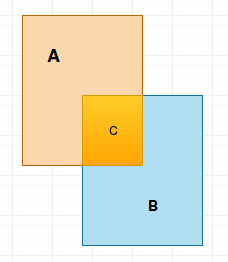

集合 C 是集合 A 与集合 B 的交集，在目标检测中 IOU 就是上面两种集合的比值：$IOU=\frac{A∩B}{A∪B}$

IOU衡量两个Bounding Boxes的重叠程度：
- IOU为0时，两个Bounding Boxes不重叠，没有交集
- IOU为1时，两个Bounding Boxes完全重叠
- IOU取值区间为0~1，数值越高表示重叠程度越高

In [10]:
class YoloV1Loss(nn.Module):
    def __init__(self, featureSize=7, boxesNumber=2, classesNumber=20, coord=5.0, noobj=0.5):
        super(YoloV1Loss, self).__init__()
        self.featureSize = featureSize
        self.boxesNumber = boxesNumber
        self.classesNumber = classesNumber
        self.coord = coord
        self.noobj = noobj
    
    def computeIOU(self, bbox1, bbox2):
        b1x1y1 = bbox1[:, :2] - bbox1[:, 2:] ** 2 # [N, (x1,y1)=2]
        b1x2y2 = bbox1[:, :2] + bbox1[:, 2:] ** 2 # [N, (x2,y2)=2]
        b2x1y1 = bbox2[:, :2] - bbox2[:, 2:] ** 2 # [M, (x1,y1)=2]
        b2x2y2 = bbox2[:, :2] + bbox2[:, 2:] ** 2 # [M, (x1,y1)=2]
        
        box1 = torch.cat((b1x1y1.view(-1, 2), b1x2y2.view(-1, 2)), dim=1) # [N,4], 4=[x1,y1,x2,y2]
        box2 = torch.cat((b2x1y1.view(-1, 2), b2x2y2.view(-1, 2)), dim=1) # [M,4], 4=[x1,y1,x2,y2]
        N = box1.size(0)
        M = box2.size(0)

        tl = torch.max(
            box1[:, :2].unsqueeze(1).expand(N, M, 2),  # [N,2] -> [N,1,2] -> [N,M,2]
            box2[:, :2].unsqueeze(0).expand(N, M, 2),  # [M,2] -> [1,M,2] -> [N,M,2]
        )
        br = torch.min(
            box1[:, 2:].unsqueeze(1).expand(N, M, 2),  # [N,2] -> [N,1,2] -> [N,M,2]
            box2[:, 2:].unsqueeze(0).expand(N, M, 2),  # [M,2] -> [1,M,2] -> [N,M,2]
        )

        wh = br - tl  # [N,M,2]
        wh[(wh<0).detach()] = 0
        inter = wh[:, :, 0] * wh[:, :, 1]  # [N,M]

        area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])  # [N,]
        area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])  # [M,]
        area1 = area1.unsqueeze(1).expand_as(inter)  # [N,] -> [N,1] -> [N,M]
        area2 = area2.unsqueeze(0).expand_as(inter)  # [M,] -> [1,M] -> [N,M]

        iou = inter / (area1 + area2 - inter)
        return iou
    
    def forward(self, predict, target):
        N = 5 * self.boxesNumber + self.classesNumber
        batchSize = predict.size(0)
        
        coordMask = target[:, :, :, 4] > 0
        noobjMask = target[:, :, :, 4] = 0
        coordMask = coordMask.unsqueeze(-1).expand_as(target)
        noobjMask = noobjMask.unsqueeze(-1).expand_as(target)
        
        coordPredict = predict[coordMask].view(-1, N)
        bboxPredict = coordPredict[:, :5 * self.boxesNumber].contiguous().view(-1, 5)
        classPredict = coordPredict[:, 5 * self.boxesNumber:]
        
        coordTarget = target[coordMask].view(-1, N)
        bboxTarget = coordTarget[:, :5 * self.boxesNumber].contiguous().view(-1, 5)
        classTarget = coordTarget[:, 5 * self.boxesNumber:]
        
        noobjPredict = predict[noobjMask].view(-1, N)
        noobjTarget = target[noobjMask].view(-1, N)
        
        noobjConfidenceMask = torch.ByteTensor(noobjPredict.size().fill_(0))
        for box in range(self.boxesNumber):
            noobjConfidenceMask[:, 4 + box * 5] = 1
        noobjPredictConfidence = noobjPredict[noobjConfidenceMask]
        noobjTargetConfidence = noobjTarget[noobjConfidenceMask]
        noobjLoss = F.mse_loss(noobjPredictConfidence, noobjTargetConfidence, reduction="sum")
        
        # 计算包含对象的单元的损失
        coordResponseMask = torch.ByteTensor(bboxTarget.size()).fill_(0)
        coordNotResponseMask = torch.ByteTensor(bboxTarget.size()).fill_(1)
        bboxTargetIou = torch.zeros(bboxTarget.size())
        
        # 为每个目标bbox选择IoU最高的预测bbox
        for i in range(0, bboxTarget.size(0), self.boxesNumber):
            pred = bboxPredict[i: i + self.boxesNumber]
            predxyxy = Variable(torch.FloatTensor(pred.size()))
            predxyxy[:,  :2] = pred[:, :2] / float(self.featureSize) - 0.5 * pred[:, 2:4]
            predxyxy[:, 2::] = pred[:, :2] / float(self.featureSize) - 0.5 * pred[:, 2:4]
            
            targ = bboxTarget[i]
            targ = bboxTarget[i].view(-1, 5)
            targxyxy = Variable(torch.FloatTensor(targ.size()))
            targxyxy[:,  :2] = targ[:, :2] / float(self.featureSize) - 0.5 * targ[:, 2:4]
            targxyxy[:, 2::] = targ[:, :2] / float(self.featureSize) - 0.5 * targ[:, 2:4]
        
            iou = self.computeIOU(predxyxy[:, :4], targxyxy[:, :4])
            maxIou, maxIndex = iou.max(0)
            maxIndex = maxIndex.data
            
            coordResponseMask[i + maxIndex] = 1
            coordNotResponseMask[i + maxIndex] = 0
            
            bboxTargetIou[i + maxIndex, torch.LongTensor([4])] = (maxIndex).data
        bboxTargetIou = Variable(bboxTargetIou)
        
        bboxPredictResponse = bboxPredict[coordResponseMask].view(-1, 5)
        bboxTargetResponse = bboxTarget[coordResponseMask].view(-1, 5)
        targetIou = bboxTargetIou[coordResponseMask].view(-1, 5)
        
        loss_xy = F.mse_loss(bboxPredictResponse[:, :2], bboxTargetResponse[:, :2], reduction="sum")
        loss_wh = F.mse_loss(torch.sqrt(bboxPredictResponse[:, 2:4]), torch.sqrt(bboxTargetResponse[:, 2:4]), reduction="sum")
        loss_obj = F.mse_loss(bboxPredictResponse[:, 4], targetIou[:, 4], reduction="sum")
        loss_class = F.mse_loss(classPredict. classTarget, reduction="sum")
        
        loss = self.coord * (loss_xy + loss_wh) + loss_obj + self.noobj * noobjLoss + loss_class
        loss = loss / float(batchSize)
        
        return loss

# 测试模型和损失函数

In [11]:
trainIter = iter(trainLoader)
image, target = next(trainIter)

In [12]:
image

tensor([[[[1.0000, 1.0000, 1.0000,  ..., 0.7922, 0.7961, 0.8000],
          [1.0000, 1.0000, 1.0000,  ..., 0.7961, 0.7961, 0.7922],
          [1.0000, 1.0000, 1.0000,  ..., 0.8078, 0.8039, 0.8039],
          ...,
          [0.7961, 0.7725, 0.7843,  ..., 0.5176, 0.4824, 0.4667],
          [0.7529, 0.7569, 0.7608,  ..., 0.4196, 0.4235, 0.4667],
          [0.6980, 0.7098, 0.7333,  ..., 0.3137, 0.2941, 0.3098]],

         [[1.0000, 1.0000, 1.0000,  ..., 0.8039, 0.8078, 0.8118],
          [1.0000, 1.0000, 1.0000,  ..., 0.8078, 0.8078, 0.8039],
          [1.0000, 1.0000, 1.0000,  ..., 0.8196, 0.8157, 0.8157],
          ...,
          [0.7412, 0.7176, 0.7294,  ..., 0.4824, 0.4549, 0.4431],
          [0.6980, 0.7020, 0.7059,  ..., 0.4000, 0.4039, 0.4549],
          [0.6431, 0.6549, 0.6784,  ..., 0.2941, 0.2745, 0.2980]],

         [[1.0000, 1.0000, 1.0000,  ..., 0.9725, 0.9765, 0.9804],
          [1.0000, 1.0000, 1.0000,  ..., 0.9804, 0.9765, 0.9725],
          [1.0000, 1.0000, 1.0000,  ..., 0

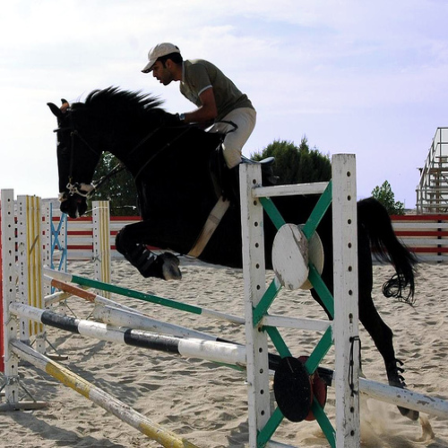

In [13]:
transforms.ToPILImage()(torch.squeeze(image)).convert("RGB")

In [14]:
target

{'annotation': {'folder': ['VOC2012'],
  'filename': ['2008_000008.jpg'],
  'source': {'database': ['The VOC2008 Database'],
   'annotation': ['PASCAL VOC2008'],
   'image': ['flickr']},
  'size': {'width': ['500'], 'height': ['442'], 'depth': ['3']},
  'segmented': ['0'],
  'object': [{'name': ['horse'],
    'pose': ['Left'],
    'truncated': ['0'],
    'occluded': ['1'],
    'bndbox': {'xmin': ['53'],
     'ymin': ['87'],
     'xmax': ['471'],
     'ymax': ['420']},
    'difficult': ['0']},
   {'name': ['person'],
    'pose': ['Unspecified'],
    'truncated': ['1'],
    'occluded': ['0'],
    'bndbox': {'xmin': ['158'],
     'ymin': ['44'],
     'xmax': ['289'],
     'ymax': ['167']},
    'difficult': ['0']}]}}

In [15]:
image = Variable(image)
YoloModel = YoloV1Model()
predict = YoloModel(image)

In [16]:
predict.size()

torch.Size([1, 1176])

In [17]:
YoloLoss = YoloV1Loss()
loss = YoloLoss(predict, target)

TypeError: unhashable type: 'slice'

In [ ]:
predict
target
loss